# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [45]:
# Installing CV2 module for image related processes
pip install opencv-python

    100% |████████████████████████████████| 88.3MB 494kB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Stored in directory: /root/.cache/pip/wheels/08/40/b7/fb2e8392888c91eb048b26ea0baa9aae808d056e3786204d0b
Successfully built opencv-python
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import imageio

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 5 #experiment with the batch size

### Plot training dataset images

(360, 360, 3)
(120, 120, 3)


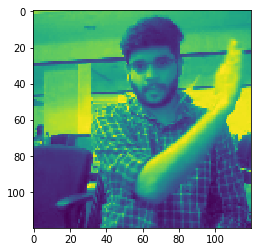

[[0.85490196 0.85098039 0.84705882 ... 0.63529412 0.63137255 0.63529412]
 [0.84705882 0.83921569 0.83137255 ... 0.63921569 0.62745098 0.63137255]
 [0.72156863 0.72156863 0.72941176 ... 0.63137255 0.62352941 0.62352941]
 ...
 [0.17254902 0.18039216 0.18039216 ... 0.17647059 0.20784314 0.18039216]
 [0.16862745 0.16470588 0.17254902 ... 0.20392157 0.15294118 0.16078431]
 [0.18823529 0.18431373 0.17647059 ... 0.15686275 0.18823529 0.17647059]]


In [4]:
img_name = 'Project_data/train/WIN_20180907_15_45_40_Pro_Left Swipe_new_Left Swipe_new/WIN_20180907_15_45_40_Pro_00051.png'
image = imageio.imread(img_name)
# The original size of the image
print(image.shape)
resized = cv2.resize(image,(120,120))
# size of the image after resize
print(resized.shape)
plt.imshow(resized[:, : , 0])
plt.show()
print(resized[:, : , 0]/255)

(360, 360, 3)
(100, 100, 3)


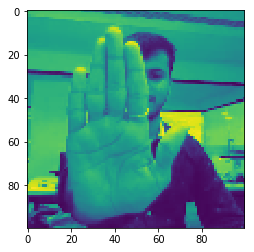

[[0.68627451 0.69019608 0.69019608 ... 0.54117647 0.5372549  0.52156863]
 [0.69411765 0.70196078 0.70980392 ... 0.5372549  0.5372549  0.53333333]
 [0.64705882 0.65490196 0.69411765 ... 0.5372549  0.54117647 0.5372549 ]
 ...
 [0.11372549 0.09411765 0.16470588 ... 0.09019608 0.11764706 0.14901961]
 [0.09411765 0.06666667 0.06666667 ... 0.07058824 0.09803922 0.07843137]
 [0.07843137 0.06666667 0.0627451  ... 0.08235294 0.21568627 0.08235294]]


In [5]:
img_name = 'Project_data/train/WIN_20180907_15_46_25_Pro_Stop Gesture_new/WIN_20180907_15_46_25_Pro_00063.png'
image = imageio.imread(img_name)
# The original size of the image
print(image.shape)
resized = cv2.resize(image,(100,100))
# size of the image after resize
print(resized.shape)
plt.imshow(resized[:, : , 0])
plt.show()
print(resized[:, : , 0]/255)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [23]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #create a list of image numbers you want to use for a particular video (two-third of images)
    img_idx = [i for i in range(0, 30) if i % 3 != 0]
    while True:
        t = np.random.permutation(folder_list)
        # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        x = len(img_idx) 
        total_frames = x
        y = 160
        z = 120
        num_batches = int(len(t)/batch_size)# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                     # Re-sizing both 120*120 (cropped) and 360*360 images into 120*160 image
                    new_image = cv2.resize(image,(120,160))
                    new_image[:,:,1:2] = 0
                    
                    batch_data[folder,idx,:,:,0] = (new_image[:,:,0] - new_image.mean())/new_image.std()   #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (new_image[:,:,1] - new_image.mean())/new_image.std()   #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (new_image[:,:,2] - new_image.mean())/new_image.std()   #normalise and feed in the image
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(folder_list) > num_batches * batch_size:
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    # I was able to find only 2 image sizes(w*h) 120*160 and 360*360, 
                    # So cropping 120*160 images on both left and right side to make it 120*160.
                    height, width , channel = image.shape
                                        
                    # Re-sizing both 120*120 (cropped) and 360*360 images into 120*160 image
                    new_image = cv2.resize(image,(120,160))
                    new_image[:,:,1:2] = 0
                    
                    batch_data[folder,idx,:,:,0] = (new_image[:,:,0] - new_image.mean())/new_image.std()   #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (new_image[:,:,1] - new_image.mean())/new_image.std()   #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (new_image[:,:,2] - new_image.mean())/new_image.std()   #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [24]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


### Show plot 

Reusable component to display Loss Curves / Accuracy curves for each models

In [25]:
def show_plots(history):
    
    # Loss Curves
    plt.figure(figsize=[8,6])
    plt.plot(history.history['loss'],'r',linewidth=3.0)
    plt.plot(history.history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)

    # Accuracy Curves
    plt.figure(figsize=[8,6])
    plt.plot(history.history['categorical_accuracy'],'r',linewidth=3.0)
    plt.plot(history.history['val_categorical_accuracy'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves',fontsize=16)

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [26]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
#write your model here

In [27]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
print ('steps_per_epoch %d' % steps_per_epoch)
print ('validation_steps %d' % validation_steps)

steps_per_epoch 133
validation_steps 20


### Experiment Model #1

In [28]:
#write your model here

# Define model
model = Sequential()
model.add(Conv3D(
    16, (3,3,3), activation='relu', input_shape=(20,120,160,3)
))
model.add(Conv3D(16, (3,3,3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(32, (3,3,3), activation='relu'))
model.add(Conv3D(32, (3,3,3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

# softmax layer
model.add(Dense(5, activation='softmax'))

# model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 18, 118, 158, 16)  1312      
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 16, 116, 156, 16)  6928      
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 8, 58, 78, 16)     0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 8, 58, 78, 16)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 6, 56, 76, 32)     13856     
_________________________________________________________________
conv3d_15 (Conv3D)           (None, 4, 54, 74, 32)     27680     
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 2, 27, 37, 32)    

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [29]:
optimiser = Adam()#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 18, 118, 158, 16)  1312      
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 16, 116, 156, 16)  6928      
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 8, 58, 78, 16)     0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 8, 58, 78, 16)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 6, 56, 76, 32)     13856     
_________________________________________________________________
conv3d_15 (Conv3D)           (None, 4, 54, 74, 32)     27680     
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 2, 27, 37, 32)    

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [30]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [31]:
#model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
model_name = 'model_1' + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

W0307 16:32:50.856498 139857203377984 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [32]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 5
Epoch 1/10
133/133 [==============================] - ETA: 0s - loss: 1.7566 - categorical_accuracy: 0.1729Source path =  Project_data/val ; batch size = 5

Epoch 00001: saving model to model_1/model.h5
133/133 [==============================] - 161s 1s/step - loss: 1.7566 - categorical_accuracy: 0.1729 - val_loss: 1.6080 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/10
133/133 [==============================] - ETA: 0s - loss: 1.6096 - categorical_accuracy: 0.1850
Epoch 00002: saving model to model_1/model.h5
133/133 [==============================] - 68s 510ms/step - loss: 1.6096 - categorical_accuracy: 0.1850 - val_loss: 1.6086 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/10
133/133 [==============================] - ETA: 0s - loss: 1.6090 - categorical_accuracy: 0.2000
Epoch 00003: saving model to model_1/model.h5
133/133 [==============================] - 68s 508ms/step - loss: 1.6090 - categorical_accuracy: 0

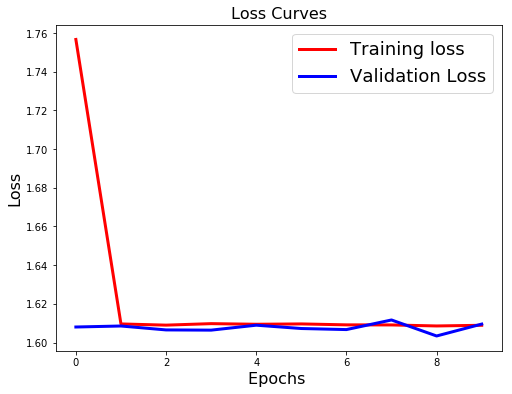

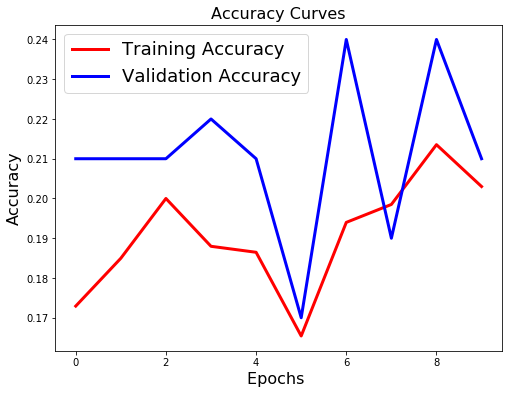

In [33]:
show_plots(history)

From model 1 we see clear Model is not able to learn. Needs to change architecture

### Experiment Model #2

In [28]:
model = Sequential()

model.add(Conv3D(
    8, (3,3,3), activation='relu', input_shape=(20,120,120,3),
    padding='same'
))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(16, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(32, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))

# softmax layer
model.add(Dense(5, activation='softmax'))

# model summary
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 20, 120, 120, 8)   656       
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 10, 60, 60, 8)     0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 10, 60, 60, 8)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 10, 60, 60, 16)    3472      
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 5, 30, 30, 16)     0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 5, 30, 30, 16)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 5, 30, 30, 32)    

In [29]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_2' + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

filepath = model_name + 'model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

W0305 14:59:53.181508 139790839867200 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


Source path =  Project_data/train ; batch size = 10


/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Epoch 1/10
66/67 [============================>.] - ETA: 0s - loss: 1.6298 - categorical_accuracy: 0.2364

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


67/67 [==============================] - ETA: 0s - loss: 1.6302 - categorical_accuracy: 0.2373Source path =  Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 1.53733, saving model to model_2/model.h5
67/67 [==============================] - 60s 895ms/step - loss: 1.6302 - categorical_accuracy: 0.2373 - val_loss: 1.5373 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 1.3855 - categorical_accuracy: 0.4104
Epoch 00002: val_loss improved from 1.53733 to 1.27475, saving model to model_2/model.h5
67/67 [==============================] - 61s 905ms/step - loss: 1.3855 - categorical_accuracy: 0.4104 - val_loss: 1.2748 - val_categorical_accuracy: 0.4400 - lr: 0.0010
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 1.3310 - categorical_accuracy: 0.4284
Epoch 00003: val_loss improved from 1.27475 to 1.19942, saving model to model_2/model.h5
67/67 [==============================] - 5

Text(0.5, 1.0, 'Accuracy Curves')

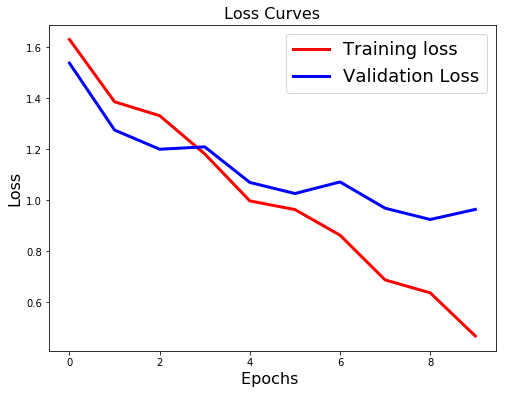

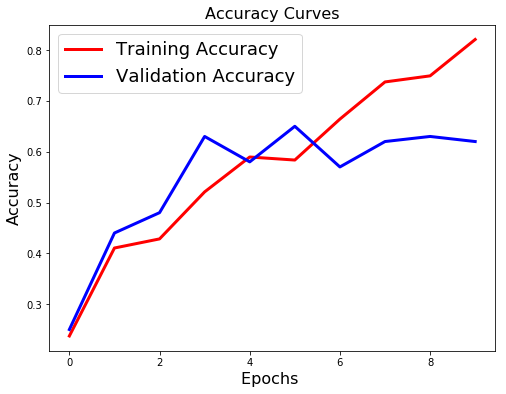

In [30]:
show_plots(history)

### Experiment Model #3

In [40]:
model = Sequential()

model.add(Conv3D(
    8, (3,3,3), activation='relu', input_shape=(20,120,120,3),
    padding='same'
))
model.add(Conv3D(8, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(16, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(32, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

# softmax layer
model.add(Dense(5, activation='softmax'))

# model summary
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 20, 120, 120, 8)   656       
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 20, 120, 120, 8)   1736      
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 10, 60, 60, 8)     0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 10, 60, 60, 8)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 10, 60, 60, 16)    3472      
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 5, 30, 30, 16)     0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 5, 30, 30, 16)    

In [41]:

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_3' + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

filepath = model_name + 'model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

W0305 15:14:31.682453 139790839867200 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Source path =  Project_data/train ; batch size = 10
Epoch 1/15
65/67 [============================>.] - ETA: 1s - loss: 1.7735 - categorical_accuracy: 0.1938

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


67/67 [==============================] - ETA: 0s - loss: 1.7678 - categorical_accuracy: 0.1985Source path =  Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 1.59376, saving model to model_3/model.h5
67/67 [==============================] - 61s 906ms/step - loss: 1.7678 - categorical_accuracy: 0.1985 - val_loss: 1.5938 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 1.5801 - categorical_accuracy: 0.2970
Epoch 00002: val_loss improved from 1.59376 to 1.54479, saving model to model_3/model.h5
67/67 [==============================] - 61s 914ms/step - loss: 1.5801 - categorical_accuracy: 0.2970 - val_loss: 1.5448 - val_categorical_accuracy: 0.3400 - lr: 0.0010
Epoch 3/15
67/67 [==============================] - ETA: 0s - loss: 1.4321 - categorical_accuracy: 0.3731
Epoch 00003: val_loss improved from 1.54479 to 1.43113, saving model to model_3/model.h5
67/67 [==============================] - 6

Text(0.5, 1.0, 'Accuracy Curves')

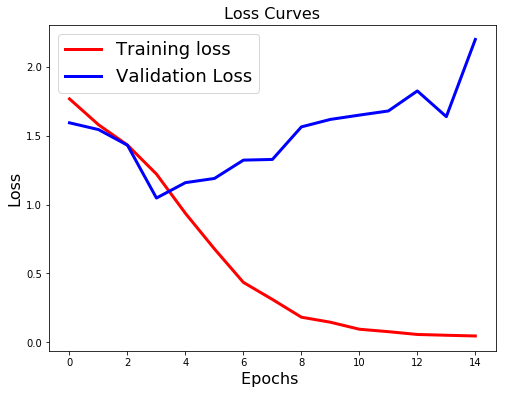

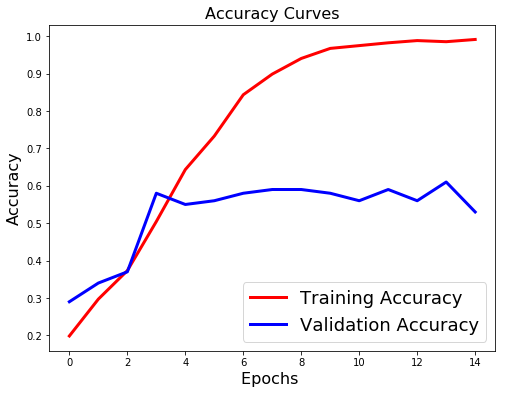

In [42]:
show_plots(history)

### Experiment Model #4

In [53]:
model = Sequential()

model.add(Conv3D(
    8, (3,3,3), input_shape=(20,120,120,3),
    padding='same'))

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv3D(8, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(16, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv3D(32, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# softmax layer
model.add(Dense(5, activation='softmax'))

# model summary
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_20 (Conv3D)           (None, 20, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_5 (Batch (None, 20, 120, 120, 8)   32        
_________________________________________________________________
activation_5 (Activation)    (None, 20, 120, 120, 8)   0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 20, 120, 120, 8)   1736      
_________________________________________________________________
batch_normalization_6 (Batch (None, 20, 120, 120, 8)   32        
_________________________________________________________________
activation_6 (Activation)    (None, 20, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 10, 60, 60, 8)    

In [54]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_4' + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

filepath = model_name + 'model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

W0305 15:36:36.879888 139790839867200 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


Source path =  Project_data/train ; batch size = 10


/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Epoch 1/15
65/67 [============================>.] - ETA: 1s - loss: 1.5953 - categorical_accuracy: 0.4462

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


67/67 [==============================] - ETA: 0s - loss: 1.5956 - categorical_accuracy: 0.4493Source path =  Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 3.34699, saving model to model_4/model.h5
67/67 [==============================] - 63s 940ms/step - loss: 1.5956 - categorical_accuracy: 0.4493 - val_loss: 3.3470 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 0.6395 - categorical_accuracy: 0.7478
Epoch 00002: val_loss improved from 3.34699 to 3.05831, saving model to model_4/model.h5
67/67 [==============================] - 66s 988ms/step - loss: 0.6395 - categorical_accuracy: 0.7478 - val_loss: 3.0583 - val_categorical_accuracy: 0.3400 - lr: 0.0010
Epoch 3/15
67/67 [==============================] - ETA: 0s - loss: 0.3664 - categorical_accuracy: 0.8851
Epoch 00003: val_loss improved from 3.05831 to 2.53437, saving model to model_4/model.h5
67/67 [==============================] - 6

Text(0.5, 1.0, 'Accuracy Curves')

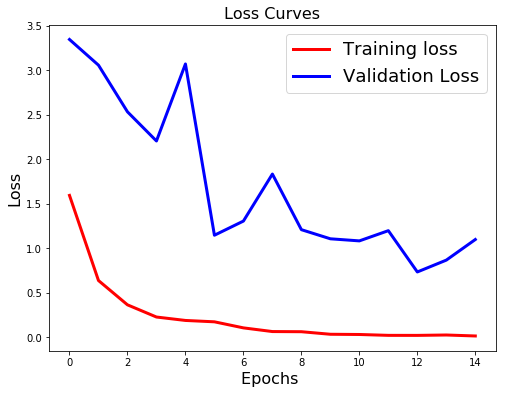

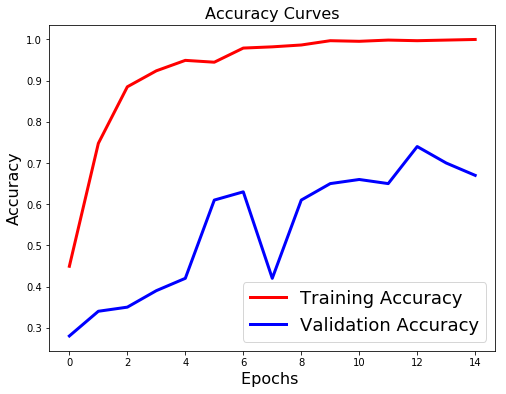

In [55]:
show_plots(history)

### Experiment Model #5

In [64]:
model = Sequential()

model.add(Conv3D(
    8, (3,3,3), input_shape=(20,120,120,3),
    padding='same'))

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv3D(8, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.5))

model.add(Conv3D(16, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv3D(16, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(5, activation='softmax'))

# model summary
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_24 (Conv3D)           (None, 20, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_10 (Batc (None, 20, 120, 120, 8)   32        
_________________________________________________________________
activation_10 (Activation)   (None, 20, 120, 120, 8)   0         
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 20, 120, 120, 8)   1736      
_________________________________________________________________
batch_normalization_11 (Batc (None, 20, 120, 120, 8)   32        
_________________________________________________________________
activation_11 (Activation)   (None, 20, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 10, 60, 60, 8)    

In [65]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_5' + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

filepath = model_name + 'model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

W0305 15:55:53.061629 139790839867200 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Source path =  Project_data/train ; batch size = 5
Epoch 1/15
131/133 [============================>.] - ETA: 0s - loss: 1.7342 - categorical_accuracy: 0.3557

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


133/133 [==============================] - ETA: 0s - loss: 1.7246 - categorical_accuracy: 0.3609Source path =  Project_data/val ; batch size = 5

Epoch 00001: val_categorical_accuracy improved from -inf to 0.32000, saving model to model_5/model.h5
133/133 [==============================] - 60s 449ms/step - loss: 1.7246 - categorical_accuracy: 0.3609 - val_loss: 1.8330 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 2/15
133/133 [==============================] - ETA: 0s - loss: 1.3072 - categorical_accuracy: 0.5188
Epoch 00002: val_categorical_accuracy improved from 0.32000 to 0.56000, saving model to model_5/model.h5
133/133 [==============================] - 61s 455ms/step - loss: 1.3072 - categorical_accuracy: 0.5188 - val_loss: 1.2490 - val_categorical_accuracy: 0.5600 - lr: 0.0010
Epoch 3/15
133/133 [==============================] - ETA: 0s - loss: 1.0934 - categorical_accuracy: 0.5759
Epoch 00003: val_categorical_accuracy did not improve from 0.56000
133/133 [=============

Text(0.5, 1.0, 'Accuracy Curves')

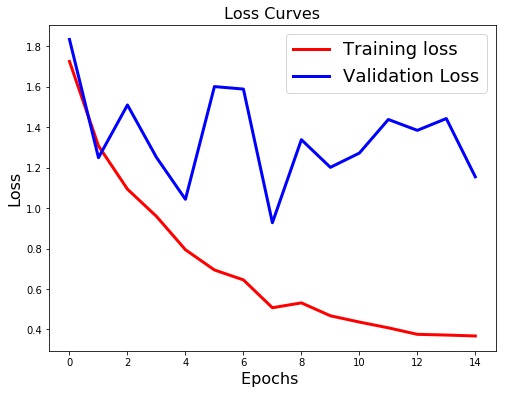

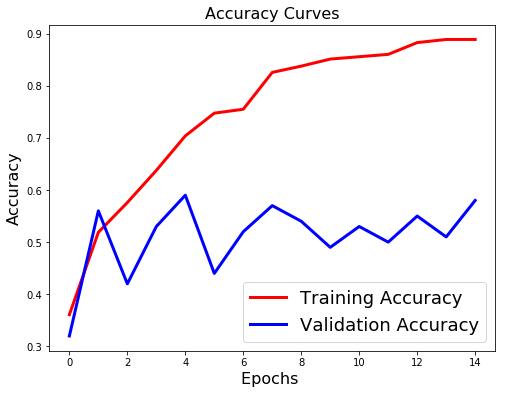

In [66]:
show_plots(history)

### Expriment Model #6

In [75]:
model = Sequential()

model.add(Conv3D(
    8, (3,3,3), input_shape=(20,120,120,3),
    padding='same'))

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv3D(16, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(5, activation='softmax'))

# model summary
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_28 (Conv3D)           (None, 20, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_15 (Batc (None, 20, 120, 120, 8)   32        
_________________________________________________________________
activation_15 (Activation)   (None, 20, 120, 120, 8)   0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 20, 120, 120, 8)   0         
_________________________________________________________________
conv3d_29 (Conv3D)           (None, 20, 120, 120, 16)  3472      
_________________________________________________________________
batch_normalization_16 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
activation_16 (Activation)   (None, 20, 120, 120, 16) 

In [76]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_6' + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

filepath = model_name + 'model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

W0305 16:13:31.697265 139790839867200 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Source path =  Project_data/train ; batch size = 5
Epoch 1/15
131/133 [============================>.] - ETA: 0s - loss: 1.8551 - categorical_accuracy: 0.2992

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


133/133 [==============================] - ETA: 0s - loss: 1.8462 - categorical_accuracy: 0.3023Source path =  Project_data/val ; batch size = 5

Epoch 00001: val_categorical_accuracy improved from -inf to 0.31000, saving model to model_6/model.h5
133/133 [==============================] - 60s 455ms/step - loss: 1.8462 - categorical_accuracy: 0.3023 - val_loss: 3.2928 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 2/15
133/133 [==============================] - ETA: 0s - loss: 1.5315 - categorical_accuracy: 0.4150
Epoch 00002: val_categorical_accuracy did not improve from 0.31000
133/133 [==============================] - 59s 444ms/step - loss: 1.5315 - categorical_accuracy: 0.4150 - val_loss: 3.0508 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/15
133/133 [==============================] - ETA: 0s - loss: 1.3590 - categorical_accuracy: 0.4346
Epoch 00003: val_categorical_accuracy did not improve from 0.31000
133/133 [==============================] - 59s 446ms/step - 

Text(0.5, 1.0, 'Accuracy Curves')

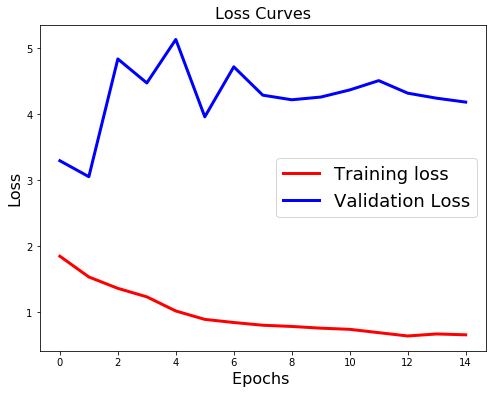

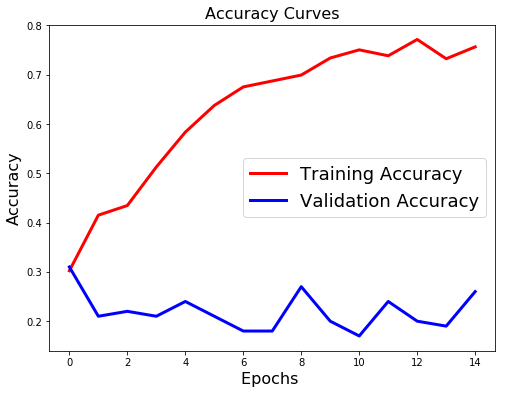

In [77]:
show_plots(history)

### Experiment Model #7

In [88]:

model = Sequential()

model.add(Conv3D(
    8, (3,3,3), input_shape=(20,120,120,3),
    padding='same'))

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv3D(8, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(16, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv3D(16, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# softmax layer
model.add(Dense(5, activation='softmax'))

# model summary
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_36 (Conv3D)           (None, 20, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_27 (Batc (None, 20, 120, 120, 8)   32        
_________________________________________________________________
activation_27 (Activation)   (None, 20, 120, 120, 8)   0         
_________________________________________________________________
conv3d_37 (Conv3D)           (None, 20, 120, 120, 8)   1736      
_________________________________________________________________
batch_normalization_28 (Batc (None, 20, 120, 120, 8)   32        
_________________________________________________________________
activation_28 (Activation)   (None, 20, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_24 (MaxPooling (None, 10, 60, 60, 8)    

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_7' + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

filepath = model_name + 'model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

W0305 16:31:58.529555 139790839867200 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Source path =  Project_data/train ; batch size = 5
Epoch 1/40
131/133 [============================>.] - ETA: 0s - loss: 1.6882 - categorical_accuracy: 0.3038

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


133/133 [==============================] - ETA: 0s - loss: 1.6936 - categorical_accuracy: 0.3008Source path =  Project_data/val ; batch size = 5

Epoch 00001: val_categorical_accuracy improved from -inf to 0.27000, saving model to model_7/model.h5
133/133 [==============================] - 59s 446ms/step - loss: 1.6936 - categorical_accuracy: 0.3008 - val_loss: 2.1091 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/40
133/133 [==============================] - ETA: 0s - loss: 1.3877 - categorical_accuracy: 0.4571
Epoch 00002: val_categorical_accuracy improved from 0.27000 to 0.37000, saving model to model_7/model.h5
133/133 [==============================] - 59s 443ms/step - loss: 1.3877 - categorical_accuracy: 0.4571 - val_loss: 1.6985 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 3/40
133/133 [==============================] - ETA: 0s - loss: 1.2173 - categorical_accuracy: 0.5083
Epoch 00003: val_categorical_accuracy improved from 0.37000 to 0.53000, saving model to m

Epoch 23/40
133/133 [==============================] - ETA: 0s - loss: 0.2056 - categorical_accuracy: 0.9398
Epoch 00023: val_categorical_accuracy did not improve from 0.79000
133/133 [==============================] - 56s 423ms/step - loss: 0.2056 - categorical_accuracy: 0.9398 - val_loss: 0.5567 - val_categorical_accuracy: 0.7700 - lr: 3.1250e-05
Epoch 24/40
133/133 [==============================] - ETA: 0s - loss: 0.2225 - categorical_accuracy: 0.9308
Epoch 00024: val_categorical_accuracy did not improve from 0.79000
133/133 [==============================] - 56s 421ms/step - loss: 0.2225 - categorical_accuracy: 0.9308 - val_loss: 0.5448 - val_categorical_accuracy: 0.7800 - lr: 3.1250e-05
Epoch 25/40
133/133 [==============================] - ETA: 0s - loss: 0.2883 - categorical_accuracy: 0.9098
Epoch 00025: val_categorical_accuracy did not improve from 0.79000
133/133 [==============================] - 57s 426ms/step - loss: 0.2883 - categorical_accuracy: 0.9098 - val_loss: 0.6087

Text(0.5, 1.0, 'Accuracy Curves')

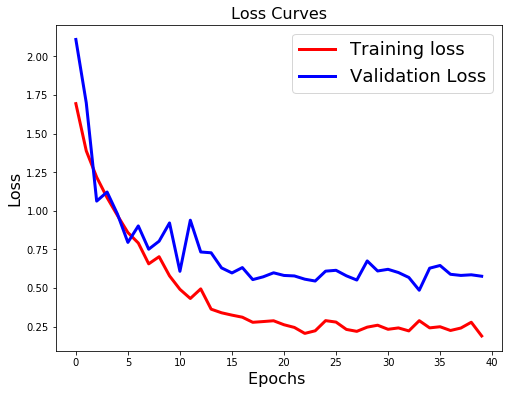

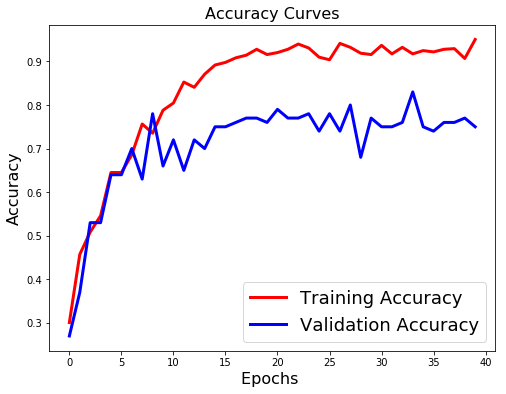

In [90]:
show_plots(history)

### Experiment Model #8

In [46]:

model = Sequential()

model.add(Conv3D(
    8, (3,3,3), input_shape=(20,120,120,3),
    padding='same'))

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv3D(8, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(16, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv3D(16, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# softmax layer
model.add(Dense(5, activation='softmax'))

# model summary
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_23 (Conv3D)           (None, 20, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_16 (Batc (None, 20, 120, 120, 8)   32        
_________________________________________________________________
activation_16 (Activation)   (None, 20, 120, 120, 8)   0         
_________________________________________________________________
conv3d_24 (Conv3D)           (None, 20, 120, 120, 8)   1736      
_________________________________________________________________
batch_normalization_17 (Batc (None, 20, 120, 120, 8)   32        
_________________________________________________________________
activation_17 (Activation)   (None, 20, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_14 (MaxPooling (None, 10, 60, 60, 8)    

In [47]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_8_4' + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

filepath = model_name + 'model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

W0307 08:09:56.525545 140296967501632 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


Source path =  Project_data/train ; batch size = 5
Epoch 1/50
133/133 [==============================] - ETA: 0s - loss: 1.7323 - categorical_accuracy: 0.3113Source path =  Project_data/val ; batch size = 5

Epoch 00001: val_categorical_accuracy improved from -inf to 0.16000, saving model to model_8_4/model.h5
133/133 [==============================] - 61s 459ms/step - loss: 1.7323 - categorical_accuracy: 0.3113 - val_loss: 3.0752 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/50
133/133 [==============================] - ETA: 0s - loss: 1.4940 - categorical_accuracy: 0.4000
Epoch 00002: val_categorical_accuracy improved from 0.16000 to 0.30000, saving model to model_8_4/model.h5
133/133 [==============================] - 60s 453ms/step - loss: 1.4940 - categorical_accuracy: 0.4000 - val_loss: 2.0211 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 3/50
133/133 [==============================] - ETA: 0s - loss: 1.4149 - categorical_accuracy: 0.4226
Epoch 00003: val_catego

Epoch 22/50
133/133 [==============================] - ETA: 0s - loss: 0.5412 - categorical_accuracy: 0.7910
Epoch 00022: val_categorical_accuracy did not improve from 0.77000
133/133 [==============================] - 58s 437ms/step - loss: 0.5412 - categorical_accuracy: 0.7910 - val_loss: 0.6718 - val_categorical_accuracy: 0.7200 - lr: 4.6656e-05
Epoch 23/50
133/133 [==============================] - ETA: 0s - loss: 0.5380 - categorical_accuracy: 0.8120
Epoch 00023: val_categorical_accuracy improved from 0.77000 to 0.79000, saving model to model_8_4/model.h5
133/133 [==============================] - 58s 438ms/step - loss: 0.5380 - categorical_accuracy: 0.8120 - val_loss: 0.5619 - val_categorical_accuracy: 0.7900 - lr: 4.6656e-05
Epoch 24/50
133/133 [==============================] - ETA: 0s - loss: 0.5327 - categorical_accuracy: 0.7865
Epoch 00024: val_categorical_accuracy did not improve from 0.79000
133/133 [==============================] - 59s 442ms/step - loss: 0.5327 - categor

Epoch 44/50
133/133 [==============================] - ETA: 0s - loss: 0.4863 - categorical_accuracy: 0.8301
Epoch 00044: val_categorical_accuracy did not improve from 0.82000

Epoch 00044: ReduceLROnPlateau reducing learning rate to 1.3060694072919432e-06.
133/133 [==============================] - 59s 443ms/step - loss: 0.4863 - categorical_accuracy: 0.8301 - val_loss: 0.6151 - val_categorical_accuracy: 0.7800 - lr: 2.1768e-06
Epoch 45/50
133/133 [==============================] - ETA: 0s - loss: 0.4885 - categorical_accuracy: 0.8180
Epoch 00045: val_categorical_accuracy did not improve from 0.82000
133/133 [==============================] - 58s 434ms/step - loss: 0.4885 - categorical_accuracy: 0.8180 - val_loss: 0.6415 - val_categorical_accuracy: 0.7300 - lr: 1.3061e-06
Epoch 46/50
133/133 [==============================] - ETA: 0s - loss: 0.5348 - categorical_accuracy: 0.8045
Epoch 00046: val_categorical_accuracy did not improve from 0.82000

Epoch 00046: ReduceLROnPlateau reducing

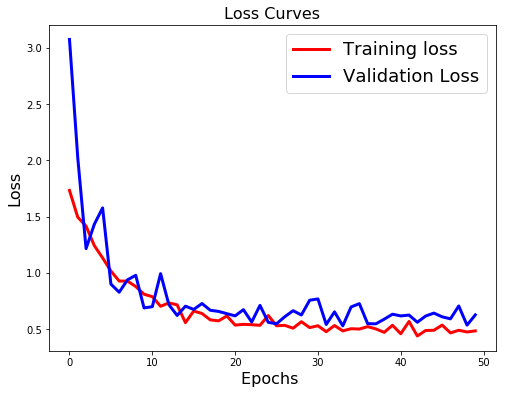

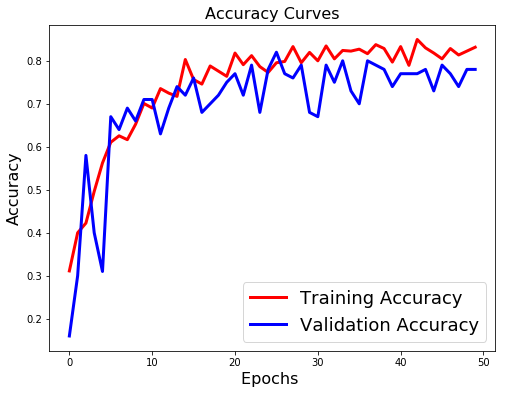

In [48]:
show_plots(history)

### Experiment Model #8_1

In [74]:

model = Sequential()

model.add(Conv3D(
    8, (3,3,3), input_shape=(20,120,120,3),
    padding='same'))

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv3D(8, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(16, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv3D(16, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# softmax layer
model.add(Dense(5, activation='softmax'))

# model summary
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_41 (Conv3D)           (None, 20, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_40 (Batc (None, 20, 120, 120, 8)   32        
_________________________________________________________________
activation_40 (Activation)   (None, 20, 120, 120, 8)   0         
_________________________________________________________________
conv3d_42 (Conv3D)           (None, 20, 120, 120, 8)   1736      
_________________________________________________________________
batch_normalization_41 (Batc (None, 20, 120, 120, 8)   32        
_________________________________________________________________
activation_41 (Activation)   (None, 20, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_26 (MaxPooling (None, 10, 60, 60, 8)    

In [75]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_8_7' + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

W0307 10:03:58.477262 140296967501632 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


Source path =  Project_data/train ; batch size = 5
Epoch 1/50
133/133 [==============================] - ETA: 0s - loss: 1.6495 - categorical_accuracy: 0.3203Source path =  Project_data/val ; batch size = 5

Epoch 00001: val_categorical_accuracy improved from -inf to 0.26000, saving model to model_8_7/model.h5
133/133 [==============================] - 61s 460ms/step - loss: 1.6495 - categorical_accuracy: 0.3203 - val_loss: 2.5628 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/50
133/133 [==============================] - ETA: 0s - loss: 1.2340 - categorical_accuracy: 0.5068
Epoch 00004: val_categorical_accuracy did not improve from 0.47000
133/133 [==============================] - 60s 450ms/step - loss: 1.2340 - categorical_accuracy: 0.5068 - val_loss: 1.6191 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 5/50
133/133 [==============================] - ETA: 0s - loss: 1.1439 - categorical_accuracy: 0.5489
Epoch 00005: val_categorical_accuracy improved from 0.47000 to 

Epoch 24/50
133/133 [==============================] - ETA: 0s - loss: 0.5513 - categorical_accuracy: 0.7850
Epoch 00024: val_categorical_accuracy improved from 0.72000 to 0.74000, saving model to model_8_7/model.h5
133/133 [==============================] - 59s 446ms/step - loss: 0.5513 - categorical_accuracy: 0.7850 - val_loss: 0.6563 - val_categorical_accuracy: 0.7400 - lr: 5.7648e-05
Epoch 25/50
133/133 [==============================] - ETA: 0s - loss: 0.4930 - categorical_accuracy: 0.8241
Epoch 00025: val_categorical_accuracy did not improve from 0.74000

Epoch 00025: ReduceLROnPlateau reducing learning rate to 4.0353603617404586e-05.
133/133 [==============================] - 60s 449ms/step - loss: 0.4930 - categorical_accuracy: 0.8241 - val_loss: 0.8563 - val_categorical_accuracy: 0.7000 - lr: 5.7648e-05
Epoch 26/50
133/133 [==============================] - ETA: 0s - loss: 0.5048 - categorical_accuracy: 0.8000
Epoch 00026: val_categorical_accuracy did not improve from 0.74000


Epoch 45/50
133/133 [==============================] - ETA: 0s - loss: 0.4475 - categorical_accuracy: 0.8556
Epoch 00045: val_categorical_accuracy did not improve from 0.76000

Epoch 00045: ReduceLROnPlateau reducing learning rate to 1.1398894002923043e-06.
133/133 [==============================] - 60s 448ms/step - loss: 0.4475 - categorical_accuracy: 0.8556 - val_loss: 0.7469 - val_categorical_accuracy: 0.6700 - lr: 1.6284e-06
Epoch 46/50
133/133 [==============================] - ETA: 0s - loss: 0.4448 - categorical_accuracy: 0.8406
Epoch 00046: val_categorical_accuracy did not improve from 0.76000
133/133 [==============================] - 60s 454ms/step - loss: 0.4448 - categorical_accuracy: 0.8406 - val_loss: 0.7263 - val_categorical_accuracy: 0.7100 - lr: 1.1399e-06
Epoch 47/50
133/133 [==============================] - ETA: 0s - loss: 0.4409 - categorical_accuracy: 0.8541
Epoch 00047: val_categorical_accuracy did not improve from 0.76000

Epoch 00047: ReduceLROnPlateau reducing

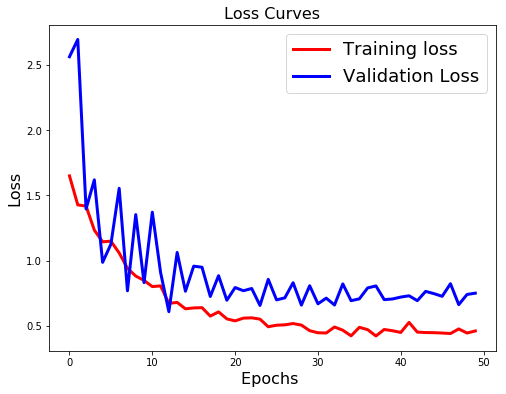

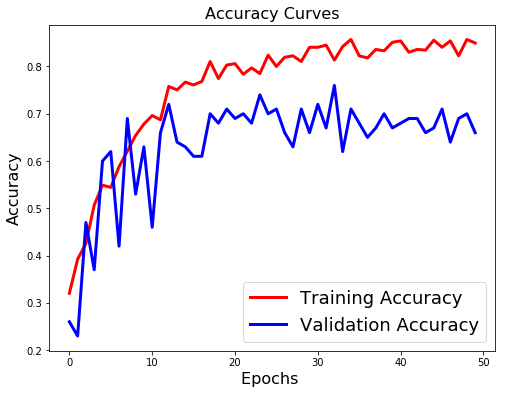

In [76]:
show_plots(history)

### Experiment Model #9

In [101]:
model = Sequential()

model.add(Conv3D(
    8, (3,3,3), input_shape=(20,100,100,3),
    padding='same'))

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv3D(8, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(16, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv3D(16, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# softmax layer
model.add(Dense(5, activation='softmax'))

# model summary
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_46 (Conv3D)           (None, 20, 100, 100, 8)   656       
_________________________________________________________________
batch_normalization_41 (Batc (None, 20, 100, 100, 8)   32        
_________________________________________________________________
activation_41 (Activation)   (None, 20, 100, 100, 8)   0         
_________________________________________________________________
conv3d_47 (Conv3D)           (None, 20, 100, 100, 8)   1736      
_________________________________________________________________
batch_normalization_42 (Batc (None, 20, 100, 100, 8)   32        
_________________________________________________________________
activation_42 (Activation)   (None, 20, 100, 100, 8)   0         
_________________________________________________________________
max_pooling3d_30 (MaxPooling (None, 10, 50, 50, 8)   

In [102]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_9' + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

filepath = model_name + 'model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

W0305 17:18:13.498476 139790839867200 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Source path =  Project_data/train ; batch size = 5
Epoch 1/40
132/133 [============================>.] - ETA: 0s - loss: 1.6171 - categorical_accuracy: 0.3439

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


133/133 [==============================] - ETA: 0s - loss: 1.6149 - categorical_accuracy: 0.3444Source path =  Project_data/val ; batch size = 5

Epoch 00001: val_categorical_accuracy improved from -inf to 0.24000, saving model to model_9/model.h5
133/133 [==============================] - 52s 392ms/step - loss: 1.6149 - categorical_accuracy: 0.3444 - val_loss: 2.9016 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/40
133/133 [==============================] - ETA: 0s - loss: 1.4057 - categorical_accuracy: 0.4406
Epoch 00002: val_categorical_accuracy improved from 0.24000 to 0.41000, saving model to model_9/model.h5
133/133 [==============================] - 52s 392ms/step - loss: 1.4057 - categorical_accuracy: 0.4406 - val_loss: 2.7189 - val_categorical_accuracy: 0.4100 - lr: 0.0010
Epoch 3/40
133/133 [==============================] - ETA: 0s - loss: 1.2447 - categorical_accuracy: 0.5143
Epoch 00003: val_categorical_accuracy did not improve from 0.41000
133/133 [=============

Epoch 23/40
133/133 [==============================] - ETA: 0s - loss: 0.2333 - categorical_accuracy: 0.9368
Epoch 00023: val_categorical_accuracy did not improve from 0.77000
133/133 [==============================] - 51s 381ms/step - loss: 0.2333 - categorical_accuracy: 0.9368 - val_loss: 0.6755 - val_categorical_accuracy: 0.7700 - lr: 6.2500e-05
Epoch 24/40
133/133 [==============================] - ETA: 0s - loss: 0.2165 - categorical_accuracy: 0.9414
Epoch 00024: val_categorical_accuracy improved from 0.77000 to 0.79000, saving model to model_9/model.h5
133/133 [==============================] - 50s 378ms/step - loss: 0.2165 - categorical_accuracy: 0.9414 - val_loss: 0.5993 - val_categorical_accuracy: 0.7900 - lr: 6.2500e-05
Epoch 25/40
133/133 [==============================] - ETA: 0s - loss: 0.2699 - categorical_accuracy: 0.9083
Epoch 00025: val_categorical_accuracy did not improve from 0.79000
133/133 [==============================] - 50s 374ms/step - loss: 0.2699 - categoric

Text(0.5, 1.0, 'Accuracy Curves')

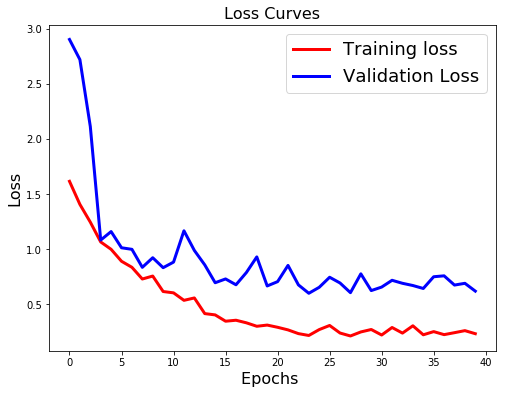

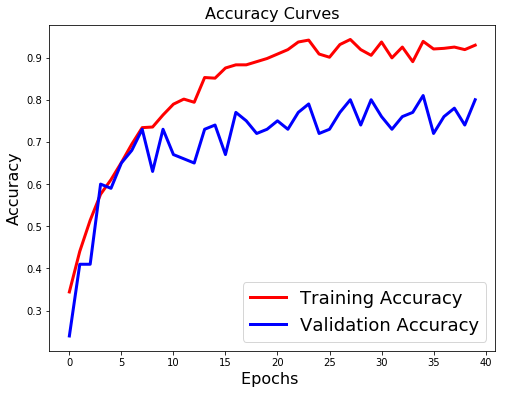

In [103]:
show_plots(history)

### Experiment Model #10 : Conv 2D + RNN(LSTM/GRU)

In [9]:

from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Reshape, Lambda
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Conv2D, LSTM, TimeDistributed, Flatten, Input, GRU, GlobalAveragePooling2D
from keras.applications import VGG19

In [10]:

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print ('steps_per_epoch %d' % steps_per_epoch)
print ('validation_steps %d' % validation_steps)

steps_per_epoch 133
validation_steps 20


In [113]:
input_shape = (100, 100, 3)
model = Sequential()
x_input = Input(shape= input_shape)

x_output = Conv2D(filters=8, kernel_size=(3,3), padding='same')(x_input)
x_output = BatchNormalization()(x_output)
x_output = Activation('relu')(x_output)
x_output = Conv2D(filters=8, kernel_size=(3,3),padding='same')(x_output)
x_output = BatchNormalization()(x_output)
x_output = Activation('relu')(x_output)
x_output = MaxPooling2D(pool_size=(2, 2))(x_output)
x_output = Dropout(0.25)(x_output)

x_output = Conv2D(filters=16, kernel_size=(3,3), padding='same')(x_output)
x_output = BatchNormalization()(x_output)
x_output = Activation('relu')(x_output)
x_output = Conv2D(filters=16, kernel_size=(3,3), )(x_output)
x_output = BatchNormalization()(x_output)
x_output = Activation('relu')(x_output)
x_output = MaxPooling2D(pool_size=(2, 2))(x_output)
x_output = Dropout(0.25)(x_output)


x_output = Conv2D(filters=32, kernel_size=(3,3), padding='same')(x_output)
x_output = BatchNormalization()(x_output)
x_output = Activation('relu')(x_output)
x_output = MaxPooling2D(pool_size=(2, 2))(x_output)
x_output = Dropout(0.25)(x_output)

x_output = Conv2D(filters=64, kernel_size=(3,3), padding='same')(x_output)
x_output = BatchNormalization()(x_output)
x_output = Activation('relu')(x_output)
x_output = MaxPooling2D(pool_size=(2, 2))(x_output)
x_output = Dropout(0.25)(x_output)

base_model = Model(x_input, x_output)

model.add(TimeDistributed(base_model, input_shape=base_model.input_shape))
model.add(TimeDistributed(Flatten(input_shape=base_model.input_shape[1:])))
model.add(GRU(256, activation='relu', recurrent_activation='hard_sigmoid', dropout=0.2))
model.add(Dense(5, activation='softmax'))
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

W0305 17:56:41.659672 139790839867200 recurrent_v2.py:385] Layer gru will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 6, 6, 64)    28008     
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 2304)        0         
_________________________________________________________________
gru (GRU)                    (None, 256)               1967616   
_________________________________________________________________
dense_29 (Dense)             (None, 5)                 1285      
Total params: 1,996,909
Trainable params: 1,996,621
Non-trainable params: 288
_________________________________________________________________
None


In [114]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
model_name = 'model_10' + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

filepath = model_name + 'model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=5, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

W0305 17:56:46.325690 139790839867200 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Source path =  Project_data/train ; batch size = 5
Epoch 1/5
132/133 [============================>.] - ETA: 0s - loss: 1.8742 - categorical_accuracy: 0.2955

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


133/133 [==============================] - ETA: 0s - loss: 1.8755 - categorical_accuracy: 0.2932Source path =  Project_data/val ; batch size = 5

Epoch 00001: val_categorical_accuracy improved from -inf to 0.21000, saving model to model_10/model.h5
133/133 [==============================] - 54s 404ms/step - loss: 1.8755 - categorical_accuracy: 0.2932 - val_loss: 1.7384 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/5
133/133 [==============================] - ETA: 0s - loss: 1.3907 - categorical_accuracy: 0.4075
Epoch 00002: val_categorical_accuracy improved from 0.21000 to 0.37000, saving model to model_10/model.h5
133/133 [==============================] - 52s 394ms/step - loss: 1.3907 - categorical_accuracy: 0.4075 - val_loss: 1.4771 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 3/5
133/133 [==============================] - ETA: 0s - loss: 1.2173 - categorical_accuracy: 0.5053
Epoch 00003: val_categorical_accuracy improved from 0.37000 to 0.60000, saving model to m

Text(0.5, 1.0, 'Accuracy Curves')

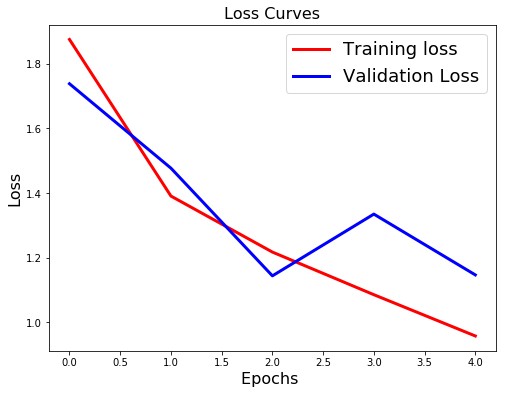

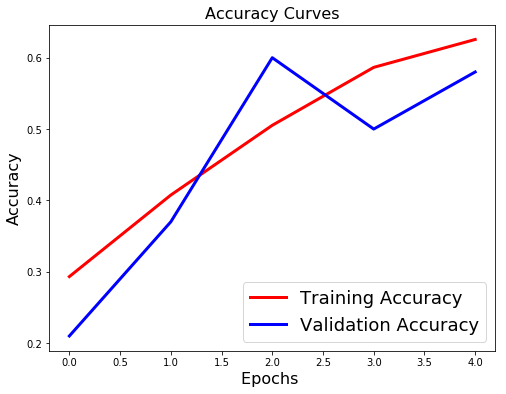

In [115]:
show_plots(history)

In [116]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=5, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Epoch 1/5
131/133 [============================>.] - ETA: 0s - loss: 0.9108 - categorical_accuracy: 0.6290

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


133/133 [==============================] - ETA: 0s - loss: 0.9059 - categorical_accuracy: 0.6316
Epoch 00001: val_categorical_accuracy improved from 0.60000 to 0.62000, saving model to model_10/model.h5
133/133 [==============================] - 52s 393ms/step - loss: 0.9059 - categorical_accuracy: 0.6316 - val_loss: 1.0220 - val_categorical_accuracy: 0.6200 - lr: 5.0000e-04
Epoch 2/5
133/133 [==============================] - ETA: 0s - loss: 0.8434 - categorical_accuracy: 0.6632
Epoch 00002: val_categorical_accuracy did not improve from 0.62000
133/133 [==============================] - 52s 388ms/step - loss: 0.8434 - categorical_accuracy: 0.6632 - val_loss: 1.2895 - val_categorical_accuracy: 0.5300 - lr: 5.0000e-04
Epoch 3/5
133/133 [==============================] - ETA: 0s - loss: 0.7171 - categorical_accuracy: 0.7263
Epoch 00003: val_categorical_accuracy improved from 0.62000 to 0.66000, saving model to model_10/model.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.

In [117]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=5, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Epoch 1/5
130/133 [============================>.] - ETA: 0s - loss: 0.5669 - categorical_accuracy: 0.7908

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


133/133 [==============================] - ETA: 0s - loss: 0.5630 - categorical_accuracy: 0.7910
Epoch 00001: val_categorical_accuracy did not improve from 0.66000
133/133 [==============================] - 51s 387ms/step - loss: 0.5630 - categorical_accuracy: 0.7910 - val_loss: 1.2505 - val_categorical_accuracy: 0.5800 - lr: 1.2500e-04
Epoch 2/5
133/133 [==============================] - ETA: 0s - loss: 0.6061 - categorical_accuracy: 0.7759
Epoch 00002: val_categorical_accuracy did not improve from 0.66000
133/133 [==============================] - 51s 384ms/step - loss: 0.6061 - categorical_accuracy: 0.7759 - val_loss: 1.2461 - val_categorical_accuracy: 0.5900 - lr: 1.2500e-04
Epoch 3/5
133/133 [==============================] - ETA: 0s - loss: 0.5534 - categorical_accuracy: 0.7895
Epoch 00003: val_categorical_accuracy did not improve from 0.66000
133/133 [==============================] - 51s 385ms/step - loss: 0.5534 - categorical_accuracy: 0.7895 - val_loss: 1.2572 - val_categoric

### Model 11 Transfer learning 

In [11]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# freeze the layers in base model
for layer in base_model.layers:
    layer.trainable = False
model = Sequential()

model.add(TimeDistributed(base_model, input_shape=base_model.input_shape))
model.add(TimeDistributed(Flatten(input_shape=base_model.input_shape[1:])))
model.add(GRU(256, activation='relu', recurrent_activation='hard_sigmoid', dropout=0.2))
model.add(Dense(5, activation='softmax'))
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

80142336/80134624 [==============================] - 1s 0us/step


W0306 09:15:35.875058 140679823009600 recurrent_v2.py:385] Layer gru will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 3, 3, 512)   20024384  
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 4608)        0         
_________________________________________________________________
gru (GRU)                    (None, 256)               3737088   
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 23,762,757
Trainable params: 3,738,373
Non-trainable params: 20,024,384
_________________________________________________________________
None


In [12]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
model_name = 'model_VGGNET_TL' + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

filepath = model_name + 'model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

W0306 09:15:45.509114 140679823009600 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


In [13]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

W0306 09:15:58.802676 140679823009600 deprecation.py:323] From <ipython-input-13-0dfb963d10d6>:3: Model.fit_generator (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
Please use Model.fit, which supports generators.
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Source path =  Project_data/train ; batch size = 5
Epoch 1/20
131/133 [============================>.] - ETA: 1s - loss: 1.4132 - categorical_accuracy: 0.4260

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


133/133 [==============================] - ETA: 0s - loss: 1.4112 - categorical_accuracy: 0.4241Source path =  Project_data/val ; batch size = 5

Epoch 00001: val_categorical_accuracy improved from -inf to 0.56000, saving model to model_VGGNET_TL/model.h5
133/133 [==============================] - 149s 1s/step - loss: 1.4112 - categorical_accuracy: 0.4241 - val_loss: 1.1956 - val_categorical_accuracy: 0.5600 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.8844 - categorical_accuracy: 0.6797
Epoch 00002: val_categorical_accuracy did not improve from 0.56000
133/133 [==============================] - 58s 438ms/step - loss: 0.8844 - categorical_accuracy: 0.6797 - val_loss: 1.4005 - val_categorical_accuracy: 0.4500 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.6261 - categorical_accuracy: 0.7774
Epoch 00003: val_categorical_accuracy improved from 0.56000 to 0.64000, saving model to model_VGGNET_TL/model.h5
133/133 